# MPC Surrogate Training Pipeline

This notebook implements the complete training and evaluation pipeline for approximating MPC policies using neural networks.

## Dataset Structure
- **States**: Joint positions and velocities (6D) - [q1, q2, q3, q̇1, q̇2, q̇3]
- **Targets**: End-effector target positions (3D) - [x, y, z]
- **Actions**: MPC torques (3D) - [τ1, τ2, τ3]

The goal is to learn a mapping: (state, target) → MPC torques

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import json
import os
from tqdm import tqdm
import time
import copy
from torch.nn.utils.rnn import pad_sequence
import random

def compute_direction_accuracy(y_true, y_pred):
    """
    Sum the number of time the sign of the predicted torque matches the true torque.
    """
    return np.sum(np.sign(y_true) == np.sign(y_pred)) / (3 * len(y_true))

torch.manual_seed(42)
np.random.seed(42)

INPUT_DIR = "../data/"
OUTPUT_DIR = "../results/pytorch_comparison/"

DATA_PATH = os.path.join(INPUT_DIR, "robot_mpc_dataset.h5")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

def _select_device():
    """Prefer CUDA, then Intel GPU via XPU, else CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    # Intel GPU via oneAPI / XPU
    if hasattr(torch, "xpu") and hasattr(torch.xpu, "is_available") and torch.xpu.is_available():
        return torch.device("xpu")
    return torch.device("cpu")

DEVICE = _select_device()
print(f"Using device: {DEVICE}")


Using device: xpu


## Data Preparation

In [10]:
class MPCDataset(Dataset):
    def __init__(self, filepath, episode_keys, mode="mlp", augment=False, window_size=1):
        """
        mode: 'mlp' (flattens trajectories) or 'rnn' (keeps trajectories intact)
        window_size: number of past steps of state history to include (MLP only).
        """
        super().__init__()
        self.augment = augment
        self.mode = mode
        self.window_size = max(1, int(window_size))
        self.data = []  # (inputs, actions) tuples

        with h5py.File(filepath, "r") as f:
            grp_eps = f["episodes"]
            for ep in episode_keys:
                s = torch.from_numpy(grp_eps[ep]["states"][:]).float()  # (T, 6)
                t = torch.from_numpy(grp_eps[ep]["targets"][:]).float()  # (T, 3)
                a = torch.from_numpy(grp_eps[ep]["actions"][:]).float()  # (T, 3)

                # states + targets as input -> (T, 9)
                inp = torch.cat([s, t], dim=-1)
                self.data.append((inp, a))

        if self.mode == "mlp":
            # Build sliding-window samples when window_size > 1
            inputs_list, actions_list = [], []
            if self.window_size == 1:
                inputs_list.append(torch.cat([x[0] for x in self.data], dim=0))
                actions_list.append(torch.cat([x[1] for x in self.data], dim=0))
                self.inputs = torch.cat(inputs_list, dim=0)
                self.actions = torch.cat(actions_list, dim=0)
            else:
                for inp, act in self.data:
                    states = inp[:, :6]
                    targets = inp[:, 6:]
                    T = states.shape[0]
                    if T < 1:
                        continue
                    # Start from i=0 and pad with ZEROS if needed
                    for i in range(T):
                        # Get window: states[max(0, i-window_size+1):i+1]
                        start_idx = max(0, i - self.window_size + 1)
                        window_states = states[start_idx:i + 1]  # shape: (variable_len, 6)
                        
                        # Pad with ZEROS if window is incomplete (early in episode)
                        if window_states.shape[0] < self.window_size:
                            padding_size = self.window_size - window_states.shape[0]
                            padding = torch.zeros(padding_size, 6)  # Zero padding
                            window_states = torch.cat([padding, window_states], dim=0)
                        
                        window_states_flat = window_states.reshape(-1)  # (window_size*6)
                        target_now = targets[i]  # (3)
                        x = torch.cat([window_states_flat, target_now], dim=0)  # (window_size*6 + 3)
                        inputs_list.append(x)
                        actions_list.append(act[i])
                
                self.inputs = torch.stack(inputs_list) if inputs_list else torch.empty(0, self.window_size * 6 + 3)
                self.actions = torch.stack(actions_list) if actions_list else torch.empty(0, 3)

    def __len__(self):
        return len(self.inputs) if self.mode == "mlp" else len(self.data)

    def __getitem__(self, idx):
        if self.mode == "mlp":
            x, y = self.inputs[idx], self.actions[idx]
            if self.augment:
                noise_state = torch.randn(min(len(x) - 3, self.window_size * 6)) * 0.01
                x[:self.window_size * 6] += noise_state
                y = y + torch.randn_like(y) * 0.005
            return x, y
        else:
            x, y = self.data[idx]  # (T, 9), (T, 3)
            if self.augment:
                noise_x = torch.randn_like(x)
                noise_x[:, 6:] = 0  # no noise on targets
                x = x + (noise_x * 0.01)
                y = y + (torch.randn_like(y) * 0.005)
            return x, y


def collate_rnn(batch):
    inputs, actions = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in inputs])

    # pad variable lengths (T0, T1...) to max length in batch
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T_max, 9)
    padded_actions = pad_sequence(actions, batch_first=True)  # (B, T_max, 3)

    return padded_inputs, padded_actions, lengths

def create_dataloaders(filepath, train_ratio=0.8, val_ratio=0.1, batch_size=32, dataset_type="mlp", window_size=1):
    """
    Creates Train (80%), Validation (10%), and Test (10%) dataloaders.
    window_size applies only to MLP mode.
    """
    with h5py.File(filepath, "r") as f:
        keys = np.array(sorted(f["episodes"].keys()))
        # if dataset_type == "mlp":
        #   # we figured out during scaling experiment only 50% of the dataset is sufficient
        #   truncated_len = int(len(keys) * 0.5)
        #   keys = keys[:truncated_len]

    np.random.shuffle(keys)

    n_total = len(keys)
    train_end = int(n_total * train_ratio)
    val_end = int(n_total * (train_ratio + val_ratio))

    train_keys = keys[:train_end]
    val_keys = keys[train_end:val_end]
    test_keys = keys[val_end:]  # remainder (approx 10%)

    if dataset_type == "mlp":
        train_ds = MPCDataset(filepath, train_keys, mode="mlp", augment=True, window_size=window_size)
        val_ds = MPCDataset(filepath, val_keys, mode="mlp", augment=False, window_size=window_size)
        test_ds = MPCDataset(filepath, test_keys, mode="mlp", augment=False, window_size=window_size)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    elif dataset_type == "rnn":
        train_ds = MPCDataset(filepath, train_keys, mode="rnn", augment=True)
        val_ds = MPCDataset(filepath, val_keys, mode="rnn", augment=False)
        test_ds = MPCDataset(filepath, test_keys, mode="rnn", augment=False)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_rnn, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    print(f"Split sizes: Train={len(train_keys)}, Val={len(val_keys)}, Test={len(test_keys)} | window_size={window_size}")

    return train_dl, val_dl, test_dl

# Data vizualization

Visualizing episode 225


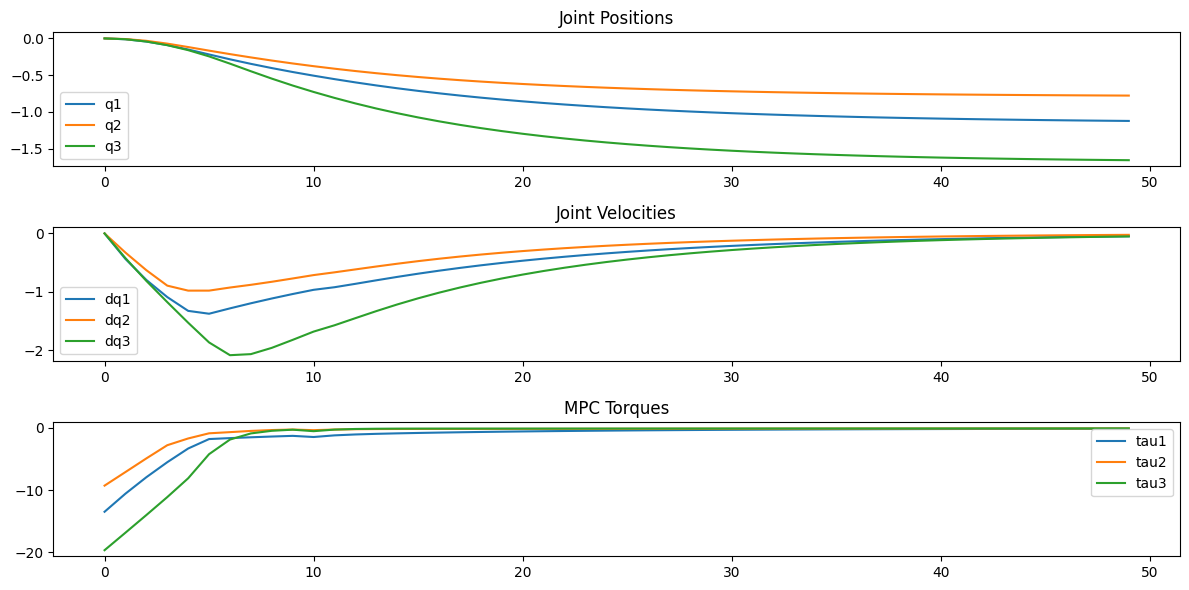

In [11]:
episodes = []
with h5py.File(DATA_PATH, "r") as f:
    keys = np.array(sorted(f["episodes"].keys()))
    for ep in keys:
        grp = f["episodes"][ep]
        states = grp["states"][:]
        targets = grp["targets"][:]
        actions = grp["actions"][:]
        episodes.append((states, targets, actions))

# pick a random episode
ep_idx = random.randint(0, len(episodes) - 1)
episode = episodes[ep_idx]
ep_states = episode[0]
ep_targets = episode[1]
ep_actions = episode[2]

print(f"Visualizing episode {ep_idx}")

# joint positions
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(ep_states[:, 0], label="q1")
plt.plot(ep_states[:, 1], label="q2")
plt.plot(ep_states[:, 2], label="q3")
plt.title("Joint Positions")
plt.legend()

# joint velocities
plt.subplot(3, 1, 2)
plt.plot(ep_states[:, 3], label="dq1")
plt.plot(ep_states[:, 4], label="dq2")
plt.plot(ep_states[:, 5], label="dq3")
plt.title("Joint Velocities")
plt.legend()

# MPC actions
plt.subplot(3, 1, 3)
plt.plot(ep_actions[:, 0], label="tau1")
plt.plot(ep_actions[:, 1], label="tau2")
plt.plot(ep_actions[:, 2], label="tau3")
plt.title("MPC Torques")
plt.legend()

plt.tight_layout()
plt.show()


## Model Architectures

In [12]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron"""
    def __init__(self, input_dim=9, hidden_dims=[128, 64], output_dim=3):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class GRU(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        # x: (B, T, 9)
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
            out_packed, hn = self.gru(x_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, hn = self.gru(x) # (B, T_max, 3)

        out = self.fc(out)
        return out

## Training and Evaluation Functions

In [13]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in train_loader:
        if len(batch) == 3: # RNN
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs, lengths)

            # Masking
            mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
            mask = mask.unsqueeze(-1).expand_as(targets)

            loss_raw = criterion(outputs, targets)
            loss = (loss_raw * mask).sum() / mask.sum()

        else: # MLP
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss_raw = criterion(outputs, targets)
            loss = loss_raw.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def evaluate(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3: #RNN
                inputs, targets, lengths = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs, lengths)

                # Masking
                mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
                mask = mask.unsqueeze(-1).expand_as(targets)

                loss_raw = criterion(outputs, targets)
                loss = (loss_raw * mask).sum() / mask.sum()

                # Filter predictions and targets for metrics
                # We flatten and remove padded values
                outputs_masked = outputs[mask].view(-1, 3)
                targets_masked = targets[mask].view(-1, 3)

                all_predictions.append(outputs_masked.cpu().numpy())
                all_targets.append(targets_masked.cpu().numpy())

            else:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss_raw = criterion(outputs, targets)
                loss = loss_raw.mean()

                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

            total_loss += loss.item()
            num_batches += 1

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)

    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
        targets = targets.reshape(-1, targets.shape[-1])

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    da = compute_direction_accuracy(targets, predictions)
    ev = explained_variance_score(targets, predictions)
    mse_per_torque = mean_squared_error(targets, predictions, multioutput="raw_values")

    return {
        'loss': total_loss / num_batches,
        'mse': mse,
        'mae': mae,
        'direction_accuracy': da,
        'explained_variance': ev,
        'predictions': predictions,
        'targets': targets,
        'mse_per_torque': mse_per_torque
    }

In [14]:
def train_model(model_name, model, train_loader, test_loader, validation_loader,
                loss_type="mse", num_epochs=50, trial=0):
    if loss_type == "mse":
        criterion = nn.MSELoss(reduction='none')
    elif loss_type == "mae":
        criterion = nn.L1Loss(reduction='none')
    else:
        raise ValueError("loss_type must be 'mse' or 'mae'")

    # keep track of both for reporting, but only optimize 'criterion'
    monitor_mse = nn.MSELoss(reduction='none')
    monitor_mae = nn.L1Loss(reduction='none')

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    results = {
        'model_name': model_name,
        'loss_type': loss_type,
        'training_history': [],
        'best_results': None,
    }

    best_val_loss = float('inf')
    pbar = tqdm(range(num_epochs), desc=f"Training {model_name}")

    try:
        for epoch in pbar:
            start_time = time.time()

            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_metrics = evaluate(model, validation_loader, criterion)

            epoch_time = time.time() - start_time

            pbar.set_postfix({
                "loss": f"{val_metrics['loss']:.4f}",
                "mse": f"{val_metrics['mse']:.4f}",
                "mae": f"{val_metrics['mae']:.4f}"
            })

            results['training_history'].append({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_metrics['loss'],
                'val_mse': val_metrics['mse'],
                'val_mae': val_metrics['mae'],
                'val_da': val_metrics['direction_accuracy'],
                'val_ev': val_metrics['explained_variance'],
                'val_mse_per_torque': val_metrics['mse_per_torque'],
                'epoch_time': epoch_time
            })

            # save best model based on the chosen loss_type
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                results['best_results'] = val_metrics.copy()
                results['best_results'].pop('predictions', None)
                results['best_results'].pop('targets', None)
                model_output_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pt')
                torch.save(model, model_output_path)

    except KeyboardInterrupt:
        print("\nInterrupted.")
    finally:
        # save the results of the best model on the test set
        best_model_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pt')
        if os.path.exists(best_model_path):
            model = torch.load(best_model_path, weights_only=False)
            final_test_metrics = evaluate(model, test_loader, criterion)

            final_test_metrics.pop('predictions', None)
            final_test_metrics.pop('targets', None)
            results['final_test_results'] = final_test_metrics

            print(f"Final Test MSE: {final_test_metrics['mse']:.5f}")
        else:
            print("failed opening best model")

        json_str = json.dumps(results, indent=2, default=lambda x: float(x) if isinstance(x, (np.floating, torch.Tensor)) else str(x))
        results_output_path = os.path.join(RESULTS_DIR, f'{model_name}_best_{loss_type}_{trial}_results.json')
        with open(results_output_path, 'w') as f:
            f.write(json_str)

    return results

# Experiment setup

In [15]:
def run_experiment_repeated(model_name, model_class, params, dataset_type, loss_type, n_runs=5, n_epochs=50, window_size=1):
    """Runs a specific configuration N times and aggregates metrics."""
    print(f"\n>>> EXPERIMENT: {model_name} | Loss: {loss_type} | Runs: {n_runs} | Window: {window_size}")

    aggregated_metrics = {
        'mse': [], 'mae': [], 'direction_accuracy': [], 'explained_variance': []
    }

    for i in range(n_runs):
        print(f"   Run {i+1}/{n_runs}...", end=" ")

        train_dl, val_dl, test_dl = create_dataloaders(DATA_PATH, batch_size=64, dataset_type=dataset_type, window_size=window_size)
        model = model_class(**params).to(DEVICE)

        res = train_model(model_name, model, train_dl, val_dl, test_dl, loss_type=loss_type, num_epochs=n_epochs, trial=i+1)

        best = res['best_results']
        aggregated_metrics['mse'].append(best['mse'])
        aggregated_metrics['mae'].append(best['mae'])
        aggregated_metrics['direction_accuracy'].append(best['direction_accuracy'])
        aggregated_metrics['explained_variance'].append(best['explained_variance'])
        print(f"Done. (MSE: {best['mse']:.4f})")

    stats = {}
    for metric, values in aggregated_metrics.items():
        stats[f'{metric}_mean'] = np.mean(values)
        stats[f'{metric}_std']  = np.std(values)

    print(f"   >>> {model_name} Finished. Avg MSE: {stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}")
    return stats

## Loss comparison

In [16]:
WINDOW_SIZE_WIN = 5

loss_configs = {
    'MLP': {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Window5': {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'GRU': {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
}

loss_types = ['mse', 'mae']
loss_results = {}

for name, config in loss_configs.items():
    for loss in loss_types:
        run_name = f"{name}_{loss}"
        window_size = config.get('window_size', 1) or 1
        stats = run_experiment_repeated(
            model_name=run_name,
            model_class=config['class'],
            params=config['params'],
            dataset_type=config['dataset_type'],
            loss_type=loss,
            n_runs=5,
            n_epochs=50,
            window_size=window_size
        )
        loss_results[run_name] = stats

print("\n=== PHASE 1 RESULTS SUMMARY ===")
print(f"{'Model Config':<20} | {'MSE (Mean ± Std)':<25} | {'MAE (Mean ± Std)':<25}")
print("-" * 75)
for name, stats in loss_results.items():
    mse_str = f"{stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}"
    mae_str = f"{stats['mae_mean']:.4f} ± {stats['mae_std']:.4f}"
    print(f"{name:<20} | {mse_str:<25} | {mae_str:<25}")


>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [07:16<00:00,  8.73s/it, loss=0.0912, mse=0.0913, mae=0.1124]



Final Test MSE: 0.03870
Done. (MSE: 0.0913)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [06:54<00:00,  8.30s/it, loss=0.0606, mse=0.0604, mae=0.1343]



Final Test MSE: 0.05154
Done. (MSE: 0.0562)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [07:36<00:00,  9.13s/it, loss=0.1344, mse=0.1350, mae=0.1230]



Final Test MSE: 0.07995
Done. (MSE: 0.1350)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [07:22<00:00,  8.86s/it, loss=0.1362, mse=0.1368, mae=0.1997]



Final Test MSE: 0.11155
Done. (MSE: 0.1179)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [06:47<00:00,  8.16s/it, loss=0.1128, mse=0.1129, mae=0.1329]



Final Test MSE: 0.12795
Done. (MSE: 0.1129)
   >>> MLP_mse Finished. Avg MSE: 0.1027 ± 0.0271

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [05:56<00:00,  7.12s/it, loss=0.0647, mse=0.1196, mae=0.0648]



Final Test MSE: 0.03480
Done. (MSE: 0.1196)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [05:49<00:00,  6.98s/it, loss=0.0707, mse=0.1429, mae=0.0708]



Final Test MSE: 0.10156
Done. (MSE: 0.1362)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [05:51<00:00,  7.02s/it, loss=0.0690, mse=0.0756, mae=0.0694]



Final Test MSE: 0.05466
Done. (MSE: 0.0817)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [05:43<00:00,  6.86s/it, loss=0.0682, mse=0.0727, mae=0.0682]



Final Test MSE: 0.17725
Done. (MSE: 0.0699)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [05:47<00:00,  6.96s/it, loss=0.0770, mse=0.0846, mae=0.0773]



Final Test MSE: 0.08121
Done. (MSE: 0.0846)
   >>> MLP_mae Finished. Avg MSE: 0.0984 ± 0.0251

>>> EXPERIMENT: MLP_Window5_mse | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [06:36<00:00,  7.94s/it, loss=0.1325, mse=0.1327, mae=0.1654]



Final Test MSE: 0.06956
Done. (MSE: 0.1149)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [06:08<00:00,  7.36s/it, loss=0.0736, mse=0.0741, mae=0.1102]



Final Test MSE: 0.09036
Done. (MSE: 0.0628)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [05:55<00:00,  7.12s/it, loss=0.0867, mse=0.0871, mae=0.1446]



Final Test MSE: 0.09792
Done. (MSE: 0.0782)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [05:47<00:00,  6.95s/it, loss=0.0919, mse=0.0921, mae=0.1424]



Final Test MSE: 0.10717
Done. (MSE: 0.0841)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [05:49<00:00,  6.99s/it, loss=0.0489, mse=0.0491, mae=0.1327]



Final Test MSE: 0.06600
Done. (MSE: 0.0376)
   >>> MLP_Window5_mse Finished. Avg MSE: 0.0755 ± 0.0254

>>> EXPERIMENT: MLP_Window5_mae | Loss: mae | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [05:51<00:00,  7.03s/it, loss=0.0625, mse=0.1503, mae=0.0626]



Final Test MSE: 0.11051
Done. (MSE: 0.1137)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [05:55<00:00,  7.11s/it, loss=0.0734, mse=0.1044, mae=0.0734]



Final Test MSE: 0.06802
Done. (MSE: 0.1090)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [05:51<00:00,  7.03s/it, loss=0.0613, mse=0.0743, mae=0.0613]



Final Test MSE: 0.15748
Done. (MSE: 0.0743)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [06:02<00:00,  7.24s/it, loss=0.0715, mse=0.0906, mae=0.0718]



Final Test MSE: 0.14414
Done. (MSE: 0.0855)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [05:56<00:00,  7.12s/it, loss=0.0672, mse=0.1173, mae=0.0672]



Final Test MSE: 0.08143
Done. (MSE: 0.1145)
   >>> MLP_Window5_mae Finished. Avg MSE: 0.0994 ± 0.0164

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:48<00:00,  3.37s/it, loss=1.2497, mse=1.2554, mae=0.2717] 



Final Test MSE: 1.17033
Done. (MSE: 1.2554)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:50<00:00,  3.40s/it, loss=1.2298, mse=1.2268, mae=0.2843] 



Final Test MSE: 1.31686
Done. (MSE: 1.2268)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:51<00:00,  3.42s/it, loss=0.9896, mse=0.9873, mae=0.2617] 



Final Test MSE: 1.22204
Done. (MSE: 0.9873)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:48<00:00,  3.38s/it, loss=1.2269, mse=1.2472, mae=0.2604] 



Final Test MSE: 1.18967
Done. (MSE: 1.2472)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:45<00:00,  3.31s/it, loss=1.2761, mse=1.2685, mae=0.2697] 



Final Test MSE: 1.24268
Done. (MSE: 1.2685)
   >>> GRU_mse Finished. Avg MSE: 1.1971 ± 0.1058

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:45<00:00,  3.32s/it, loss=0.3518, mse=2.1401, mae=0.3492]



Final Test MSE: 2.03727
Done. (MSE: 2.1401)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:48<00:00,  3.37s/it, loss=0.3355, mse=1.8769, mae=0.3357]



Final Test MSE: 2.10091
Done. (MSE: 1.9007)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:48<00:00,  3.38s/it, loss=0.3435, mse=2.0004, mae=0.3416]



Final Test MSE: 2.19840
Done. (MSE: 2.0004)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:48<00:00,  3.36s/it, loss=0.3560, mse=2.1150, mae=0.3557]



Final Test MSE: 1.93389
Done. (MSE: 2.1458)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:49<00:00,  3.38s/it, loss=0.3405, mse=2.0163, mae=0.3416]

Final Test MSE: 2.14133
Done. (MSE: 2.0163)
   >>> GRU_mae Finished. Avg MSE: 2.0407 ± 0.0925

=== PHASE 1 RESULTS SUMMARY ===
Model Config         | MSE (Mean ± Std)          | MAE (Mean ± Std)         
---------------------------------------------------------------------------
MLP_mse              | 0.1027 ± 0.0271           | 0.1259 ± 0.0077          
MLP_mae              | 0.0984 ± 0.0251           | 0.0675 ± 0.0051          
MLP_Window5_mse      | 0.0755 ± 0.0254           | 0.1110 ± 0.0093          
MLP_Window5_mae      | 0.0994 ± 0.0164           | 0.0611 ± 0.0025          
GRU_mse              | 1.1971 ± 0.1058           | 0.2696 ± 0.0086          
GRU_mae              | 2.0407 ± 0.0925           | 0.3447 ± 0.0068          


## Architecture comparison

In [17]:
BEST_LOSS = 'mse'
WINDOW_SIZE_WIN = 5

archi_configs = {
    # MLP without window
    'MLP_Small':   {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Medium':  {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Deep':    {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp', 'window_size': 1},

    # MLP with sliding window
    'MLP_Win5_Small':   {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'MLP_Win5_Medium':  {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'MLP_Win5_Deep':    {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},

    # GRU
    'GRU_Shallow': {'class': GRU, 'params': {'hidden_dim': 64,  'num_layers': 1}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Medium':  {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Deep':    {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 4}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Wide':    {'class': GRU, 'params': {'hidden_dim': 256, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
}

archi_results = {}

for name, config in archi_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type=BEST_LOSS,
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    archi_results[name] = stats


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [05:57<00:00,  7.16s/it, loss=0.1525, mse=0.1527, mae=0.1484]



Final Test MSE: 0.08954
Done. (MSE: 0.1527)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [05:57<00:00,  7.16s/it, loss=0.0800, mse=0.0803, mae=0.1461]



Final Test MSE: 0.12887
Done. (MSE: 0.0740)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [05:55<00:00,  7.12s/it, loss=0.2195, mse=0.2196, mae=0.1826]



Final Test MSE: 0.18397
Done. (MSE: 0.1926)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [05:55<00:00,  7.12s/it, loss=0.1996, mse=0.2008, mae=0.1584]



Final Test MSE: 0.11979
Done. (MSE: 0.1455)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [06:43<00:00,  8.06s/it, loss=0.1878, mse=0.1879, mae=0.1966]



Final Test MSE: 0.15766
Done. (MSE: 0.1801)
   >>> MLP_Small Finished. Avg MSE: 0.1490 ± 0.0413

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [06:18<00:00,  7.57s/it, loss=0.0675, mse=0.0679, mae=0.1332]



Final Test MSE: 0.11459
Done. (MSE: 0.0679)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [06:03<00:00,  7.27s/it, loss=0.0950, mse=0.0951, mae=0.1195]



Final Test MSE: 0.13061
Done. (MSE: 0.0909)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [05:54<00:00,  7.09s/it, loss=0.1086, mse=0.1086, mae=0.1249]



Final Test MSE: 0.05419
Done. (MSE: 0.1086)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [05:55<00:00,  7.12s/it, loss=0.1255, mse=0.1259, mae=0.1710]



Final Test MSE: 0.06600
Done. (MSE: 0.1030)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [06:06<00:00,  7.33s/it, loss=0.1802, mse=0.1806, mae=0.1242]



Final Test MSE: 0.06965
Done. (MSE: 0.1635)
   >>> MLP_Medium Finished. Avg MSE: 0.1068 ± 0.0316

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [06:34<00:00,  7.90s/it, loss=0.0351, mse=0.0351, mae=0.0730]



Final Test MSE: 0.02257
Done. (MSE: 0.0222)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [06:41<00:00,  8.02s/it, loss=0.1686, mse=0.1695, mae=0.0676]



Final Test MSE: 0.08334
Done. (MSE: 0.0753)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [06:38<00:00,  7.97s/it, loss=0.0233, mse=0.0235, mae=0.0624]



Final Test MSE: 0.15522
Done. (MSE: 0.0216)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [06:39<00:00,  7.99s/it, loss=0.1962, mse=0.1971, mae=0.1109]



Final Test MSE: 0.01868
Done. (MSE: 0.0859)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [06:47<00:00,  8.15s/it, loss=0.2012, mse=0.2019, mae=0.0674]



Final Test MSE: 0.04105
Done. (MSE: 0.0243)
   >>> MLP_Deep Finished. Avg MSE: 0.0459 ± 0.0286

>>> EXPERIMENT: MLP_Win5_Small | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [05:50<00:00,  7.00s/it, loss=0.0753, mse=0.0754, mae=0.1278]



Final Test MSE: 0.10201
Done. (MSE: 0.0754)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [05:29<00:00,  6.58s/it, loss=0.1047, mse=0.1052, mae=0.1227]



Final Test MSE: 0.12305
Done. (MSE: 0.1052)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [05:24<00:00,  6.50s/it, loss=0.1572, mse=0.1581, mae=0.1537]



Final Test MSE: 0.12403
Done. (MSE: 0.1581)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [05:22<00:00,  6.44s/it, loss=0.0867, mse=0.0869, mae=0.1437]



Final Test MSE: 0.07316
Done. (MSE: 0.0673)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [05:24<00:00,  6.49s/it, loss=0.1329, mse=0.1333, mae=0.1533]



Final Test MSE: 0.13469
Done. (MSE: 0.1245)
   >>> MLP_Win5_Small Finished. Avg MSE: 0.1061 ± 0.0331

>>> EXPERIMENT: MLP_Win5_Medium | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [05:28<00:00,  6.58s/it, loss=0.1328, mse=0.1329, mae=0.1237]



Final Test MSE: 0.19326
Done. (MSE: 0.0908)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [05:29<00:00,  6.59s/it, loss=0.1708, mse=0.1714, mae=0.1317]



Final Test MSE: 0.09314
Done. (MSE: 0.1714)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [05:26<00:00,  6.52s/it, loss=0.0576, mse=0.0578, mae=0.1038]



Final Test MSE: 0.06821
Done. (MSE: 0.0470)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [05:24<00:00,  6.50s/it, loss=0.0579, mse=0.0580, mae=0.1007]



Final Test MSE: 0.13212
Done. (MSE: 0.0580)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [05:27<00:00,  6.55s/it, loss=0.1101, mse=0.1105, mae=0.1212]



Final Test MSE: 0.05371
Done. (MSE: 0.0891)
   >>> MLP_Win5_Medium Finished. Avg MSE: 0.0913 ± 0.0436

>>> EXPERIMENT: MLP_Win5_Deep | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:05<00:00,  7.31s/it, loss=0.0644, mse=0.0645, mae=0.0794]



Final Test MSE: 0.11303
Done. (MSE: 0.0172)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:08<00:00,  7.36s/it, loss=0.6435, mse=0.6446, mae=0.1142]



Final Test MSE: 0.05389
Done. (MSE: 0.0479)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:06<00:00,  7.33s/it, loss=0.0229, mse=0.0231, mae=0.0598]



Final Test MSE: 0.03723
Done. (MSE: 0.0188)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:02<00:00,  7.26s/it, loss=0.2285, mse=0.2289, mae=0.0821]



Final Test MSE: 0.12120
Done. (MSE: 0.0308)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [06:04<00:00,  7.29s/it, loss=0.1661, mse=0.1661, mae=0.0836]



Final Test MSE: 0.19219
Done. (MSE: 0.0347)
   >>> MLP_Win5_Deep Finished. Avg MSE: 0.0299 ± 0.0113

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it, loss=2.5378, mse=2.5169, mae=0.4061] 



Final Test MSE: 2.58931
Done. (MSE: 2.5169)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it, loss=2.7907, mse=2.8238, mae=0.4499] 



Final Test MSE: 2.81642
Done. (MSE: 2.8238)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it, loss=2.5531, mse=2.5068, mae=0.4091] 



Final Test MSE: 2.78532
Done. (MSE: 2.5068)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:27<00:00,  1.74s/it, loss=2.7198, mse=2.7121, mae=0.4248] 



Final Test MSE: 2.50041
Done. (MSE: 2.7121)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it, loss=2.8846, mse=2.8547, mae=0.4249] 



Final Test MSE: 2.67517
Done. (MSE: 2.8547)
   >>> GRU_Shallow Finished. Avg MSE: 2.6829 ± 0.1475

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:45<00:00,  3.30s/it, loss=1.1313, mse=1.1205, mae=0.2644] 



Final Test MSE: 0.97561
Done. (MSE: 1.1205)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:49<00:00,  3.40s/it, loss=1.1431, mse=1.1523, mae=0.2565] 



Final Test MSE: 1.22464
Done. (MSE: 1.1523)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:43<00:00,  3.27s/it, loss=1.1083, mse=1.1020, mae=0.2658] 



Final Test MSE: 1.25190
Done. (MSE: 1.1020)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:44<00:00,  3.30s/it, loss=1.1331, mse=1.1314, mae=0.2571] 



Final Test MSE: 1.14249
Done. (MSE: 1.1314)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:44<00:00,  3.28s/it, loss=1.0447, mse=1.0608, mae=0.2484] 



Final Test MSE: 1.15819
Done. (MSE: 1.0608)
   >>> GRU_Medium Finished. Avg MSE: 1.1134 ± 0.0309

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:12<00:00,  5.05s/it, loss=0.5128, mse=0.5164, mae=0.2228]



Final Test MSE: 0.54000
Done. (MSE: 0.5164)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:12<00:00,  5.04s/it, loss=0.4718, mse=0.4715, mae=0.2229] 



Final Test MSE: 0.49413
Done. (MSE: 0.4715)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:24<00:00,  5.30s/it, loss=0.7009, mse=0.6850, mae=0.2494] 



Final Test MSE: 0.44343
Done. (MSE: 0.5589)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:17<00:00,  5.16s/it, loss=0.5286, mse=0.5346, mae=0.2240] 



Final Test MSE: 0.39984
Done. (MSE: 0.4555)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [04:29<00:00,  5.40s/it, loss=0.4313, mse=0.4355, mae=0.2167] 



Final Test MSE: 0.51631
Done. (MSE: 0.4355)
   >>> GRU_Deep Finished. Avg MSE: 0.4876 ± 0.0445

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [03:03<00:00,  3.66s/it, loss=0.6380, mse=0.6153, mae=0.1641]



Final Test MSE: 0.44635
Done. (MSE: 0.6153)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:47<00:00,  3.34s/it, loss=0.4953, mse=0.5083, mae=0.1618]



Final Test MSE: 0.46264
Done. (MSE: 0.5083)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it, loss=0.4834, mse=0.5002, mae=0.1526]



Final Test MSE: 0.51530
Done. (MSE: 0.5002)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:51<00:00,  3.42s/it, loss=0.5333, mse=0.5024, mae=0.1537]



Final Test MSE: 0.43197
Done. (MSE: 0.5024)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it, loss=0.6288, mse=0.6219, mae=0.1661]

Final Test MSE: 0.49807
Done. (MSE: 0.6219)
   >>> GRU_Wide Finished. Avg MSE: 0.5496 ± 0.0564


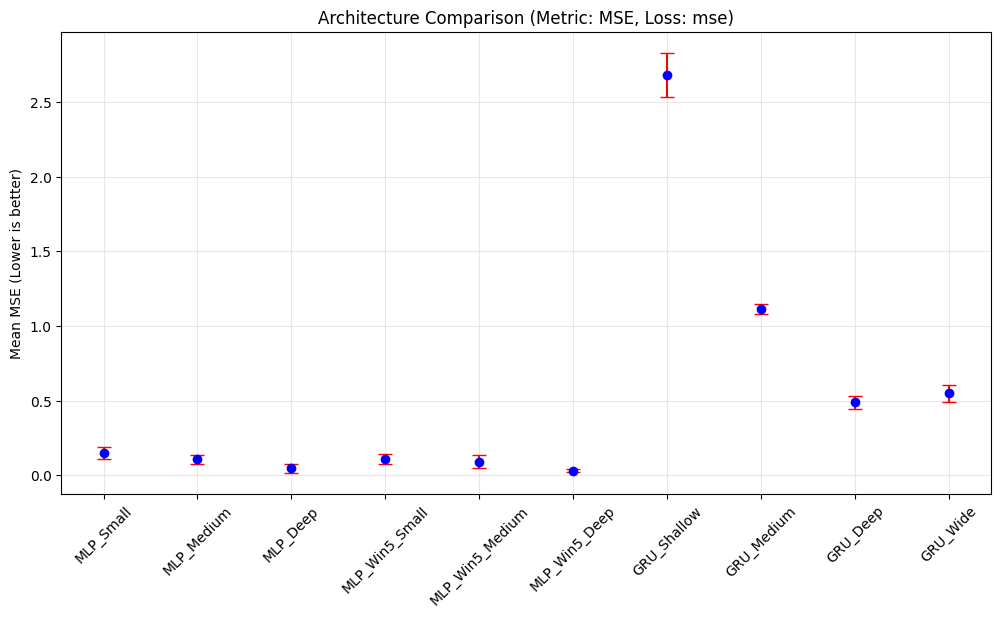


=== PHASE 2 RANKING ===
   Architecture  Mean MSE  Std Dev
  MLP_Win5_Deep  0.029891 0.011262
       MLP_Deep  0.045866 0.028590
MLP_Win5_Medium  0.091264 0.043582
 MLP_Win5_Small  0.106123 0.033138
     MLP_Medium  0.106772 0.031611
      MLP_Small  0.148993 0.041265
       GRU_Deep  0.487556 0.044538
       GRU_Wide  0.549628 0.056408
     GRU_Medium  1.113396 0.030942
    GRU_Shallow  2.682859 0.147496


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_viz = []
for name, stats in archi_results.items():
    data_viz.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df = pd.DataFrame(data_viz)

plt.figure(figsize=(12, 6))
# Plot with Error Bars
plt.errorbar(x=df['Architecture'], y=df['Mean MSE'], yerr=df['Std Dev'], fmt='o', capsize=5, ecolor='red', color='blue')
plt.title(f"Architecture Comparison (Metric: MSE, Loss: {BEST_LOSS})")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

print("\n=== PHASE 2 RANKING ===")
df_sorted = df.sort_values(by='Mean MSE')
print(df_sorted.to_string(index=False))

## With scaling and window size of 5, results are similar to MLP with window size of 1. Temporal context does not seem to help.
## Test: Scaled MLP (without sliding window) - Does scaling help?

In [19]:
# Train scaled MLP architecture WITHOUT sliding window
# Keep only the truly larger variant (Deep_Scaled) to avoid duplicate configs

scaled_nonwindowed_configs = {
    'MLP_Deep_Scaled': {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [512, 256, 128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
}

scaled_nonwindowed_results = {}

for name, config in scaled_nonwindowed_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type='mse',
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    scaled_nonwindowed_results[name] = stats


>>> EXPERIMENT: MLP_Deep_Scaled | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [06:34<00:00,  7.89s/it, loss=0.1018, mse=0.1018, mae=0.0740]



Final Test MSE: 0.02274
Done. (MSE: 0.0305)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [06:36<00:00,  7.94s/it, loss=0.0687, mse=0.0689, mae=0.0835]



Final Test MSE: 0.05068
Done. (MSE: 0.0279)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [06:44<00:00,  8.09s/it, loss=0.0756, mse=0.0757, mae=0.0888]



Final Test MSE: 0.02599
Done. (MSE: 0.0263)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [06:42<00:00,  8.05s/it, loss=0.0534, mse=0.0536, mae=0.0700]



Final Test MSE: 0.04810
Done. (MSE: 0.0191)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1
Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep_Scaled: 100%|██████████| 50/50 [06:43<00:00,  8.08s/it, loss=0.0546, mse=0.0546, mae=0.0930]



Final Test MSE: 0.17889
Done. (MSE: 0.0222)
   >>> MLP_Deep_Scaled Finished. Avg MSE: 0.0252 ± 0.0041


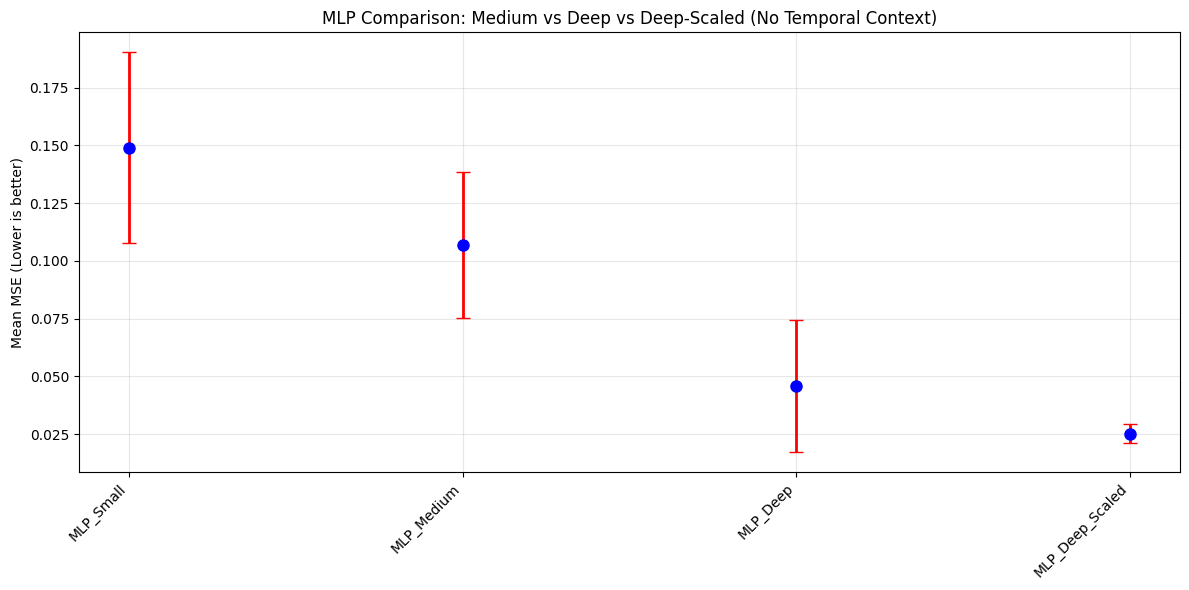


=== COMPARISON RANKING ===
(MLP_Medium vs MLP_Deep vs MLP_Deep_Scaled)
   Architecture  Mean MSE  Std Dev
MLP_Deep_Scaled  0.025202 0.004085
       MLP_Deep  0.045866 0.028590
     MLP_Medium  0.106772 0.031611
      MLP_Small  0.148993 0.041265


In [20]:
# Compare: Original non-windowed vs Deep scaled (no window)

import pandas as pd
import matplotlib.pyplot as plt

comparison_results = {}

# Add selected original non-windowed results
for name in ['MLP_Small', 'MLP_Medium', 'MLP_Deep']:
    if name in archi_results:
        comparison_results[name] = archi_results[name]

# Add deep scaled non-windowed result
if 'MLP_Deep_Scaled' in scaled_nonwindowed_results:
    comparison_results['MLP_Deep_Scaled'] = scaled_nonwindowed_results['MLP_Deep_Scaled']

# Create visualization
data_viz_comparison = []
for name, stats in comparison_results.items():
    data_viz_comparison.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df_comparison = pd.DataFrame(data_viz_comparison)

plt.figure(figsize=(12, 6))
plt.errorbar(x=df_comparison['Architecture'], y=df_comparison['Mean MSE'], yerr=df_comparison['Std Dev'], 
             fmt='o', capsize=5, ecolor='red', color='blue', markersize=8, linewidth=2)
plt.title("MLP Comparison: Medium vs Deep vs Deep-Scaled (No Temporal Context)")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== COMPARISON RANKING ===")
print("(MLP_Medium vs MLP_Deep vs MLP_Deep_Scaled)")
df_comparison_sorted = df_comparison.sort_values(by='Mean MSE')
print(df_comparison_sorted.to_string(index=False))

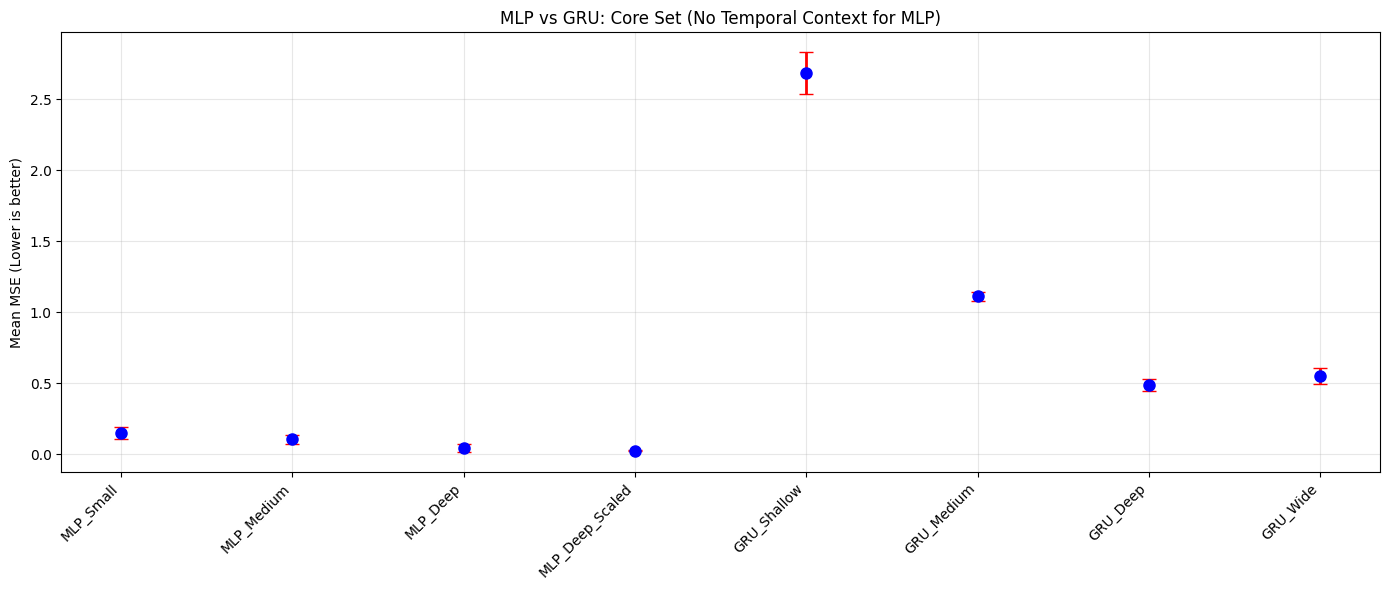


=== FULL COMPARISON RANKING ===
   Architecture  Mean MSE  Std Dev
MLP_Deep_Scaled  0.025202 0.004085
       MLP_Deep  0.045866 0.028590
     MLP_Medium  0.106772 0.031611
      MLP_Small  0.148993 0.041265
       GRU_Deep  0.487556 0.044538
       GRU_Wide  0.549628 0.056408
     GRU_Medium  1.113396 0.030942
    GRU_Shallow  2.682859 0.147496


In [21]:
# Compare: MLP core set + GRUs (includes Deep_Scaled)
# Models: MLP_Small, MLP_Medium, MLP_Deep, MLP_Deep_Scaled, GRU_Shallow/Mediu m/Deep/Wide

import pandas as pd
import matplotlib.pyplot as plt

comparison_results_full = {}

# Add MLP baselines
for name in ['MLP_Small', 'MLP_Medium', 'MLP_Deep']:
    if name in archi_results:
        comparison_results_full[name] = archi_results[name]

# Add MLP deep scaled
if 'MLP_Deep_Scaled' in scaled_nonwindowed_results:
    comparison_results_full['MLP_Deep_Scaled'] = scaled_nonwindowed_results['MLP_Deep_Scaled']

# Add GRU variants
for name in ['GRU_Shallow', 'GRU_Medium', 'GRU_Deep', 'GRU_Wide']:
    if name in archi_results:
        comparison_results_full[name] = archi_results[name]

# Build DataFrame
viz_rows = []
for name, stats in comparison_results_full.items():
    viz_rows.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df_full = pd.DataFrame(viz_rows)

plt.figure(figsize=(14, 6))
plt.errorbar(x=df_full['Architecture'], y=df_full['Mean MSE'], yerr=df_full['Std Dev'],
             fmt='o', capsize=5, ecolor='red', color='blue', markersize=8, linewidth=2)
plt.title("MLP vs GRU: Core Set (No Temporal Context for MLP)")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== FULL COMPARISON RANKING ===")
df_full_sorted = df_full.sort_values(by='Mean MSE')
print(df_full_sorted.to_string(index=False))

In [22]:
# Train SCALED MLP window-5 architecture (only Deep_Scaled) to test higher capacity with temporal context
WINDOW_SIZE_WIN = 5

window5_scaled_configs = {
    'MLP_Win5_Deep_Scaled': {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [512, 256, 128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
}

window5_scaled_results = {}

for name, config in window5_scaled_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type='mse',
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    window5_scaled_results[name] = stats


>>> EXPERIMENT: MLP_Win5_Deep_Scaled | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:41<00:00,  8.03s/it, loss=0.1653, mse=0.1660, mae=0.0888]



Final Test MSE: 0.12501
Done. (MSE: 0.0321)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:46<00:00,  8.12s/it, loss=0.0478, mse=0.0478, mae=0.0610]



Final Test MSE: 0.15881
Done. (MSE: 0.0270)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:51<00:00,  8.22s/it, loss=0.2058, mse=0.2069, mae=0.0702]



Final Test MSE: 0.11210
Done. (MSE: 0.0370)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:43<00:00,  8.07s/it, loss=0.0983, mse=0.0985, mae=0.0669]



Final Test MSE: 0.23046
Done. (MSE: 0.0246)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5
Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep_Scaled: 100%|██████████| 50/50 [06:46<00:00,  8.14s/it, loss=0.0493, mse=0.0496, mae=0.0612]



Final Test MSE: 0.04549
Done. (MSE: 0.0318)
   >>> MLP_Win5_Deep_Scaled Finished. Avg MSE: 0.0305 ± 0.0043


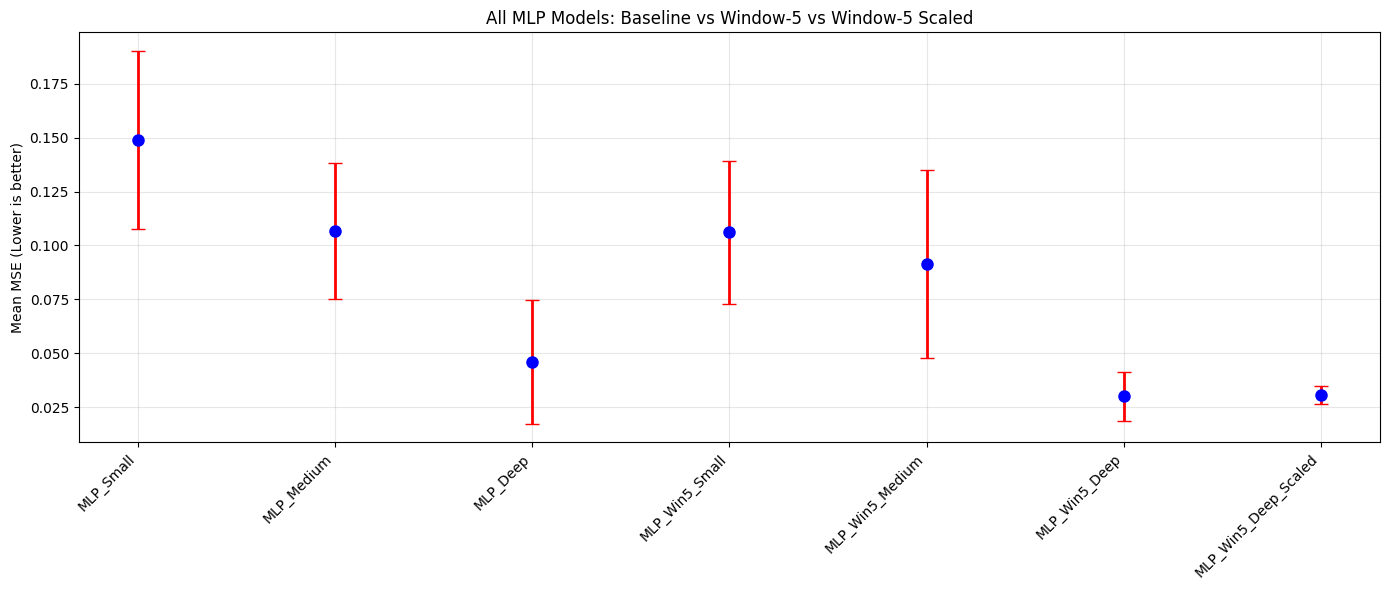


=== WINDOWED SCALING COMPARISON (7 models) ===
        Architecture  Mean MSE  Std Dev
       MLP_Win5_Deep  0.029891 0.011262
MLP_Win5_Deep_Scaled  0.030512 0.004333
            MLP_Deep  0.045866 0.028590
     MLP_Win5_Medium  0.091264 0.043582
      MLP_Win5_Small  0.106123 0.033138
          MLP_Medium  0.106772 0.031611
           MLP_Small  0.148993 0.041265


In [25]:
# Plot comparison: Baseline MLP (win=1), MLP win=5 (unscaled), and MLP win=5 Deep_Scaled

import pandas as pd
import matplotlib.pyplot as plt

comparison_win5_scaled = {}

# Baseline non-windowed
for name in ['MLP_Small', 'MLP_Medium', 'MLP_Deep']:
    if name in archi_results:
        comparison_win5_scaled[name] = archi_results[name]

# Window-5 unscaled (from archi_results)
for name in ['MLP_Win5_Small', 'MLP_Win5_Medium', 'MLP_Win5_Deep']:
    if name in archi_results:
        comparison_win5_scaled[name] = archi_results[name]

# Window-5 deep scaled (from previous cell)
if 'MLP_Win5_Deep_Scaled' in window5_scaled_results:
    comparison_win5_scaled['MLP_Win5_Deep_Scaled'] = window5_scaled_results['MLP_Win5_Deep_Scaled']

viz_rows = []
for name, stats in comparison_win5_scaled.items():
    viz_rows.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df_win5_scaled = pd.DataFrame(viz_rows)

plt.figure(figsize=(14, 6))
plt.errorbar(
    x=df_win5_scaled['Architecture'],
    y=df_win5_scaled['Mean MSE'],
    yerr=df_win5_scaled['Std Dev'],
    fmt='o', capsize=5, ecolor='red', color='blue', markersize=8, linewidth=2
)
plt.title("All MLP Models: Baseline vs Window-5 vs Window-5 Scaled")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n=== WINDOWED SCALING COMPARISON (7 models) ===")
df_win5_scaled_sorted = df_win5_scaled.sort_values(by='Mean MSE')
print(df_win5_scaled_sorted.to_string(index=False))

In [7]:
# Reload results from JSON after kernel restart
# Reads results/pytorch_comparison/results/*.json and rebuilds aggregated metrics

import os, glob, json
import numpy as np
import pandas as pd

RESULTS_JSON_DIR = os.path.join(OUTPUT_DIR, "results")

# Expected filename: {model_name}_best_{loss_type}_{trial}_results.json
def parse_filename(fname):
    base = os.path.basename(fname)
    if not base.endswith("_results.json"):
        return None, None, None
    stem = base[:-len("_results.json")]
    if "_best_" not in stem:
        return None, None, None
    model_part, rest = stem.split("_best_", 1)
    parts = rest.split("_")
    if len(parts) < 2:
        return None, None, None
    loss_type = parts[0]
    trial = parts[1]
    return model_part, loss_type, trial

records = []
for path in glob.glob(os.path.join(RESULTS_JSON_DIR, "*_results.json")):
    model_name, loss_type, trial = parse_filename(path)
    if model_name is None:
        continue
    with open(path, "r") as f:
        data = json.load(f)
    metrics = data.get("final_test_results") or data.get("best_results") or {}
    records.append({
        "model_name": model_name,
        "loss_type": loss_type,
        "trial": int(trial) if str(trial).isdigit() else trial,
        "mse": float(metrics.get("mse", np.nan)),
        "mae": float(metrics.get("mae", np.nan)),
        "direction_accuracy": float(metrics.get("direction_accuracy", np.nan)),
        "explained_variance": float(metrics.get("explained_variance", np.nan)),
    })

results_df = pd.DataFrame(records)
aggregated_results = {}

if not results_df.empty:
    grouped = results_df.groupby("model_name")
    for name, g in grouped:
        aggregated_results[name] = {
            "mse_mean": g["mse"].mean(),
            "mse_std": g["mse"].std(ddof=0),
            "mae_mean": g["mae"].mean(),
            "mae_std": g["mae"].std(ddof=0),
            "direction_accuracy_mean": g["direction_accuracy"].mean(),
            "direction_accuracy_std": g["direction_accuracy"].std(ddof=0),
            "explained_variance_mean": g["explained_variance"].mean(),
            "explained_variance_std": g["explained_variance"].std(ddof=0),
        }
else:
    print("No result files found in", RESULTS_JSON_DIR)

# Backward-compatibility for plotting cells (filter subsets if needed)
archi_results = aggregated_results
scaled_nonwindowed_results = {k: v for k, v in aggregated_results.items() if "Deep_Scaled" in k and "Win5" not in k}
window5_scaled_results = {k: v for k, v in aggregated_results.items() if "Win5_Deep_Scaled" in k}

print("Loaded results from", RESULTS_JSON_DIR)
print(f"Total files: {len(records)} | Unique models: {len(aggregated_results)}")
if not results_df.empty:
    print(results_df[["model_name", "trial", "mse", "mae"]]
          .sort_values(["model_name", "trial"]).to_string(index=False))

Loaded results from ../results/pytorch_comparison/results
Total files: 60 | Unique models: 12
          model_name  trial      mse      mae
            GRU_Deep      1 0.540003 0.232705
            GRU_Deep      2 0.494128 0.226623
            GRU_Deep      3 0.443433 0.223109
            GRU_Deep      4 0.399838 0.195552
            GRU_Deep      5 0.516314 0.227623
          GRU_Medium      1 0.975609 0.257895
          GRU_Medium      2 1.224641 0.254315
          GRU_Medium      3 1.251897 0.282817
          GRU_Medium      4 1.142488 0.264040
          GRU_Medium      5 1.158190 0.250373
         GRU_Shallow      1 2.589310 0.415051
         GRU_Shallow      2 2.816415 0.444724
         GRU_Shallow      3 2.785324 0.427519
         GRU_Shallow      4 2.500407 0.405867
         GRU_Shallow      5 2.675173 0.410977
            GRU_Wide      1 0.446355 0.153832
            GRU_Wide      2 0.462637 0.154230
            GRU_Wide      3 0.515300 0.153840
            GRU_Wide      4 0.43

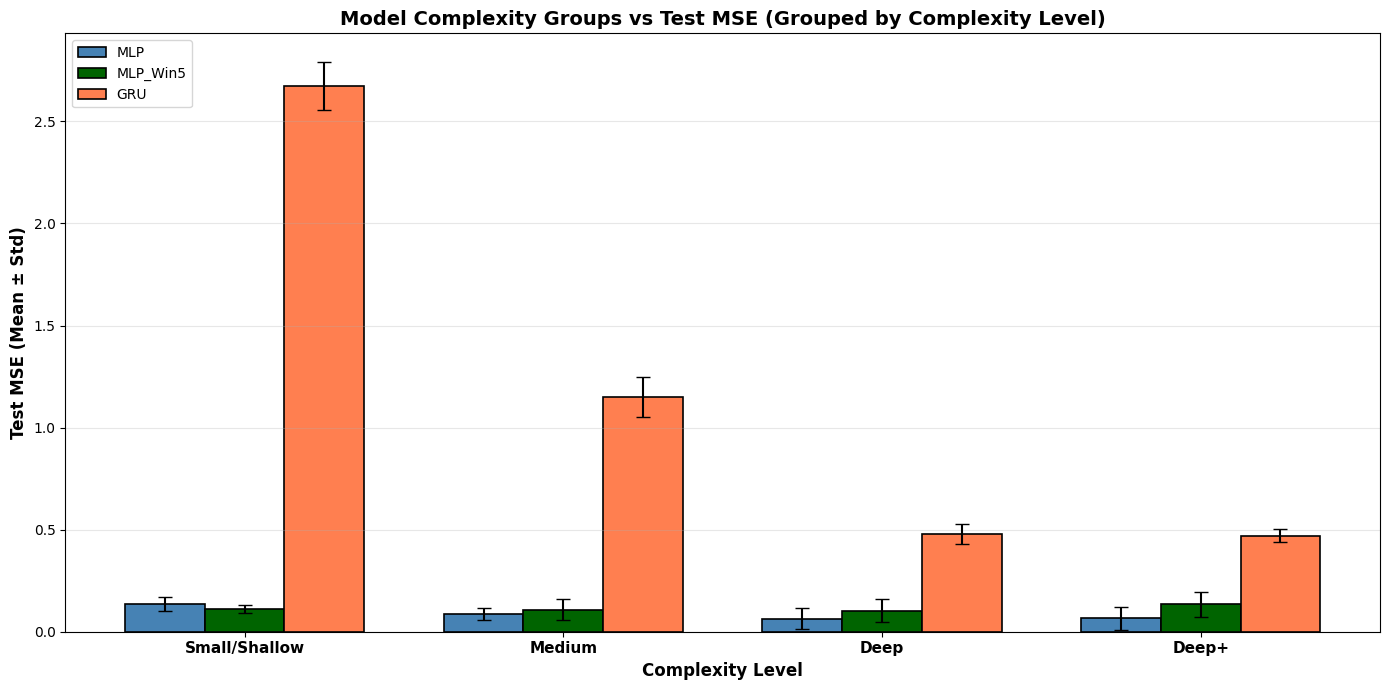


=== MODELS GROUPED BY COMPLEXITY LEVEL ===

SMALL/SHALLOW:
         Model     Type      MSE      Std
     MLP_Small      MLP 0.135966 0.032380
MLP_Win5_Small MLP_Win5 0.111389 0.021856
   GRU_Shallow      GRU 2.673326 0.118306
  Group Average MSE: 0.97356 ± 0.05751

MEDIUM:
          Model     Type      MSE      Std
     MLP_Medium      MLP 0.087007 0.029939
MLP_Win5_Medium MLP_Win5 0.108088 0.050205
     GRU_Medium      GRU 1.150565 0.096425
  Group Average MSE: 0.44855 ± 0.05886

DEEP:
        Model     Type      MSE      Std
     MLP_Deep      MLP 0.064171 0.050975
MLP_Win5_Deep MLP_Win5 0.103510 0.054996
     GRU_Deep      GRU 0.478743 0.050742
  Group Average MSE: 0.21547 ± 0.05224

DEEP+:
               Model     Type      MSE      Std
     MLP_Deep_Scaled      MLP 0.065279 0.057912
MLP_Win5_Deep_Scaled MLP_Win5 0.134373 0.060522
            GRU_Wide      GRU 0.470866 0.031293
  Group Average MSE: 0.22351 ± 0.04991


In [9]:
# Model Complexity vs MSE: Grouped chart showing all 12 models
# Models grouped by complexity level: (Small, Medium, Deep, etc.)
# Colors by model type: MLP (blue), MLP_Win5 (green), GRU (coral)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define complexity groups and assign each model to a group
complexity_groups = {
    'Small/Shallow': ['MLP_Small', 'MLP_Win5_Small', 'GRU_Shallow'],
    'Medium': ['MLP_Medium', 'MLP_Win5_Medium', 'GRU_Medium'],
    'Deep': ['MLP_Deep', 'MLP_Win5_Deep', 'GRU_Deep'],
    'Deep+': ['MLP_Deep_Scaled', 'MLP_Win5_Deep_Scaled', 'GRU_Wide'],
}

# Define colors by model type
type_colors = {
    'MLP': 'steelblue',
    'MLP_Win5': 'darkgreen',
    'GRU': 'coral',
}

def get_model_type(model_name):
    """Extract model type from model name"""
    if 'MLP_Win5' in model_name:
        return 'MLP_Win5'
    elif 'MLP' in model_name:
        return 'MLP'
    elif 'GRU' in model_name:
        return 'GRU'
    return 'Unknown'

# Collect all results
all_results = {}
all_results.update(archi_results)
all_results.update(scaled_nonwindowed_results)
all_results.update(window5_scaled_results)

# Build data for plotting
data_by_group = {group: [] for group in complexity_groups.keys()}
model_info = []

for group, models in complexity_groups.items():
    for model_name in models:
        if model_name in all_results:
            stats = all_results[model_name]
            model_type = get_model_type(model_name)
            data_by_group[group].append({
                'Model': model_name,
                'Type': model_type,
                'MSE': stats['mse_mean'],
                'Std': stats['mse_std'],
            })
            model_info.append({
                'Group': group,
                'Model': model_name,
                'Type': model_type,
                'MSE': stats['mse_mean'],
                'Std': stats['mse_std'],
            })

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Define bar positions and colors
groups = list(complexity_groups.keys())
x_positions = np.arange(len(groups))
bar_width = 0.25

# Track which types we've added to legend (to avoid duplicates)
legend_added = set()

# For each group, plot its models side by side
group_index = 0
for group in groups:
    models_in_group = data_by_group[group]
    num_models = len(models_in_group)
    
    # Calculate x positions for bars in this group
    group_x_start = group_index - (num_models - 1) * bar_width / 2
    
    for i, model_data in enumerate(models_in_group):
        x_pos = group_x_start + i * bar_width
        model_type = model_data['Type']
        color = type_colors[model_type]
        
        # Add label only once per type
        label = model_type if model_type not in legend_added else ''
        if model_type not in legend_added:
            legend_added.add(model_type)
        
        ax.bar(x_pos, model_data['MSE'], bar_width, 
               yerr=model_data['Std'], label=label,
               capsize=5, edgecolor='black', linewidth=1.2, color=color)
    
    group_index += 1

# Formatting
ax.set_xlabel('Complexity Level', fontsize=12, fontweight='bold')
ax.set_ylabel('Test MSE (Mean ± Std)', fontsize=12, fontweight='bold')
ax.set_title('Model Complexity Groups vs Test MSE (Grouped by Complexity Level)', fontsize=14, fontweight='bold')
ax.set_xticks(np.arange(len(groups)))
ax.set_xticklabels(groups, fontsize=11, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary table
df_summary = pd.DataFrame(model_info)
print("\n=== MODELS GROUPED BY COMPLEXITY LEVEL ===")
for group in groups:
    group_data = df_summary[df_summary['Group'] == group]
    print(f"\n{group.upper()}:")
    print(group_data[['Model', 'Type', 'MSE', 'Std']].to_string(index=False))
    print(f"  Group Average MSE: {group_data['MSE'].mean():.5f} ± {group_data['Std'].mean():.5f}")

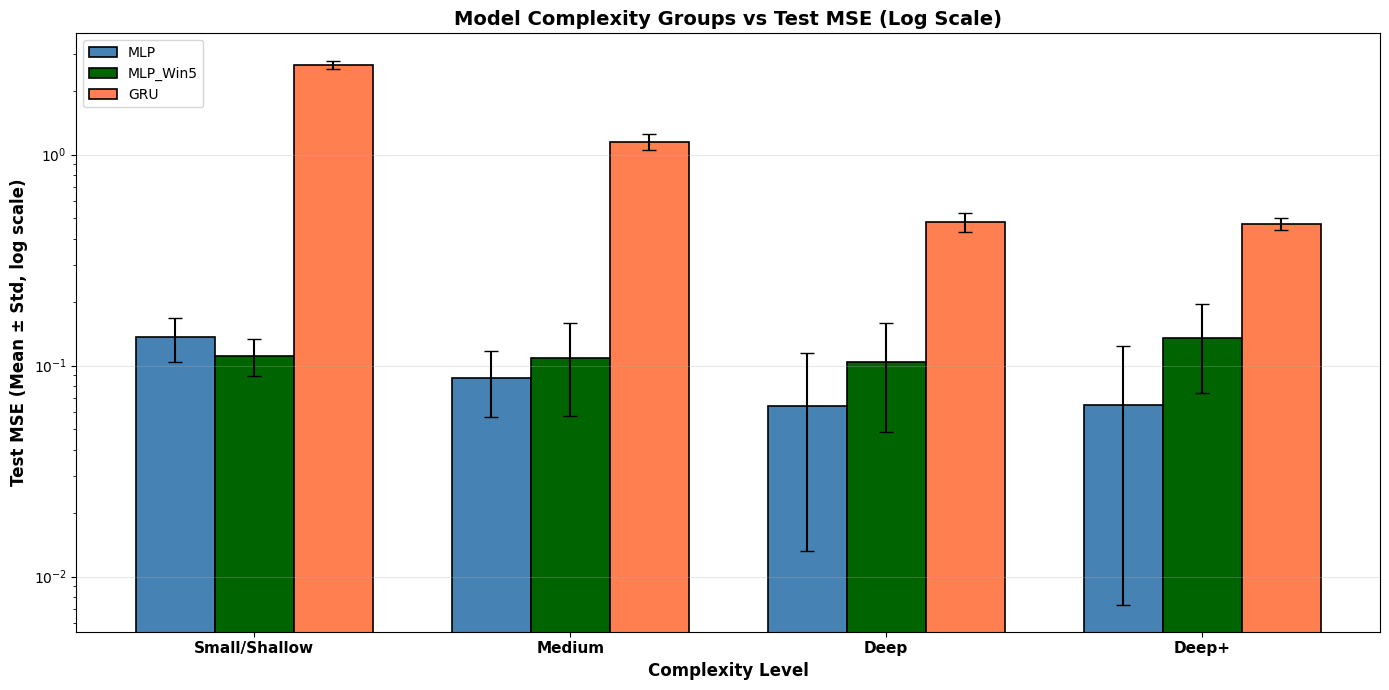


=== MODELS GROUPED BY COMPLEXITY LEVEL (LOG PLOT) ===

SMALL/SHALLOW:
         Model     Type      MSE      Std
     MLP_Small      MLP 0.135966 0.032380
MLP_Win5_Small MLP_Win5 0.111389 0.021856
   GRU_Shallow      GRU 2.673326 0.118306
  Group Average MSE: 0.97356 ± 0.05751

MEDIUM:
          Model     Type      MSE      Std
     MLP_Medium      MLP 0.087007 0.029939
MLP_Win5_Medium MLP_Win5 0.108088 0.050205
     GRU_Medium      GRU 1.150565 0.096425
  Group Average MSE: 0.44855 ± 0.05886

DEEP:
        Model     Type      MSE      Std
     MLP_Deep      MLP 0.064171 0.050975
MLP_Win5_Deep MLP_Win5 0.103510 0.054996
     GRU_Deep      GRU 0.478743 0.050742
  Group Average MSE: 0.21547 ± 0.05224

DEEP+:
               Model     Type      MSE      Std
     MLP_Deep_Scaled      MLP 0.065279 0.057912
MLP_Win5_Deep_Scaled MLP_Win5 0.134373 0.060522
            GRU_Wide      GRU 0.470866 0.031293
  Group Average MSE: 0.22351 ± 0.04991


In [10]:
# Model Complexity vs MSE (log-scale): Grouped chart showing all 12 models
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define complexity groups and assign each model to a group
complexity_groups = {
    'Small/Shallow': ['MLP_Small', 'MLP_Win5_Small', 'GRU_Shallow'],
    'Medium': ['MLP_Medium', 'MLP_Win5_Medium', 'GRU_Medium'],
    'Deep': ['MLP_Deep', 'MLP_Win5_Deep', 'GRU_Deep'],
    'Deep+': ['MLP_Deep_Scaled', 'MLP_Win5_Deep_Scaled', 'GRU_Wide'],
}

# Define colors by model type
type_colors = {
    'MLP': 'steelblue',
    'MLP_Win5': 'darkgreen',
    'GRU': 'coral',
}

def get_model_type(model_name):
    """Extract model type from model name"""
    if 'MLP_Win5' in model_name:
        return 'MLP_Win5'
    elif 'MLP' in model_name:
        return 'MLP'
    elif 'GRU' in model_name:
        return 'GRU'
    return 'Unknown'

# Collect all results
all_results = {}
all_results.update(archi_results)
all_results.update(scaled_nonwindowed_results)
all_results.update(window5_scaled_results)

# Build data for plotting
data_by_group = {group: [] for group in complexity_groups.keys()}
model_info = []

for group, models in complexity_groups.items():
    for model_name in models:
        if model_name in all_results:
            stats = all_results[model_name]
            model_type = get_model_type(model_name)
            data_by_group[group].append({
                'Model': model_name,
                'Type': model_type,
                'MSE': stats['mse_mean'],
                'Std': stats['mse_std'],
            })
            model_info.append({
                'Group': group,
                'Model': model_name,
                'Type': model_type,
                'MSE': stats['mse_mean'],
                'Std': stats['mse_std'],
            })

# Create grouped bar chart (log scale on Y)
fig, ax = plt.subplots(figsize=(14, 7))

# Define bar positions and colors
groups = list(complexity_groups.keys())
x_positions = np.arange(len(groups))
bar_width = 0.25

# Track which types we've added to legend (to avoid duplicates)
legend_added = set()

# For each group, plot its models side by side
group_index = 0
for group in groups:
    models_in_group = data_by_group[group]
    num_models = len(models_in_group)
    
    # Calculate x positions for bars in this group
    group_x_start = group_index - (num_models - 1) * bar_width / 2
    
    for i, model_data in enumerate(models_in_group):
        x_pos = group_x_start + i * bar_width
        model_type = model_data['Type']
        color = type_colors[model_type]
        
        # Add label only once per type
        label = model_type if model_type not in legend_added else ''
        if model_type not in legend_added:
            legend_added.add(model_type)
        
        ax.bar(x_pos, model_data['MSE'], bar_width,
               yerr=model_data['Std'], label=label,
               capsize=5, edgecolor='black', linewidth=1.2, color=color)
    
    group_index += 1

# Formatting
ax.set_xlabel('Complexity Level', fontsize=12, fontweight='bold')
ax.set_ylabel('Test MSE (Mean ± Std, log scale)', fontsize=12, fontweight='bold')
ax.set_title('Model Complexity Groups vs Test MSE (Log Scale)', fontsize=14, fontweight='bold')
ax.set_xticks(np.arange(len(groups)))
ax.set_xticklabels(groups, fontsize=11, fontweight='bold')
ax.set_yscale('log')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print summary table (same as linear-scale cell for reference)
df_summary = pd.DataFrame(model_info)
print("\n=== MODELS GROUPED BY COMPLEXITY LEVEL (LOG PLOT) ===")
for group in groups:
    group_data = df_summary[df_summary['Group'] == group]
    print(f"\n{group.upper()}:")
    print(group_data[['Model', 'Type', 'MSE', 'Std']].to_string(index=False))
    print(f"  Group Average MSE: {group_data['MSE'].mean():.5f} ± {group_data['Std'].mean():.5f}")